# Assignment 2
# Data Pipelines & Data Analytics Life Cycle
# Forecasting the Wind Power Production in Orkney

#### Environment and Libraries

### Setting up the environment with `venv`

It is always recommended to create a new environment for any new project to avoid dependency issues and keep a clean working space. 

Step 1: Create a virtual environment in your project directory:

python3 -m venv .venv


Step 2: Activate the virtual environment:  
For Linux/Mac:  
source .venv/bin/activate  


For Windows:  
.venv\Scripts\activate  


Step 3: Install the influxdb and MLFlow libraries using requirements.txt from https://github.itu.dk/BDM-Autumn-2024/python_env

pip install -r requirements.txt

Once your environment is set up and dependencies are installed, you are ready to proceed with your project.



### Imports

In [310]:
#Install requirements
#! pip install matplotlib mlflow numpy pandas scikit-learn seaborn influxdb jupyter

In [311]:
# You absolutely need these
from influxdb import InfluxDBClient
import mlflow

# You will probably need these
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline

# This are for example purposes. You may discard them if you don't use them.
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from mlflow.models import infer_signature
from urllib.parse import urlparse

### TODO -> HERE YOU CAN ADD ANY OTHER LIBRARIES YOU MAY NEED ###
import seaborn as sns

## Step 1: The Data

### Getting the data with InfluxDB

The data is stored in an [InfluxDB](https://www.influxdata.com/), which is a non-relational time-series database. InfluxDB can be queried using [InfluxQL](https://docs.influxdata.com/influxdb/v1.8/query_language/spec/), a "SQL-like" query language for time-series data. InfluxDB does not have tables with rows and columns, instead data is stored in measurements with fields and tags. <br><br>
**NOTE:** <em>You don't need to know much about InfluxDB syntax, but if you are interested, feel free to browse around the [documentation](https://docs.influxdata.com/).</em>

The data for this assignment is stored in a database, with one table for the weather data and another for the power generation data. To do this, we first need to create an instance of the InfluxDB Client, that will allow us to query the needed data. Let's see how this is done.

In [312]:
# Set the needed parameters to connect to the database
### THIS SHOULD NOT BE CHANGED ###
settings = {
    'host': 'influxus.itu.dk',
    'port': 8086,
    'username': 'lsda',
    'password': 'icanonlyread'
    }

# Create an InfluxDB Client instance and select the orkney database
### YOU DON'T NEED TO CHANGE ANYTHING HERE ###
client = InfluxDBClient(host=settings['host'], port=settings['port'], username=settings['username'], password=settings['password'])
client.switch_database('orkney')

As explained before, InfluxDB uses InfluxQL, a "SQL-like" syntax. We will use this to select the data we need from the correspondant tables, using our client instance. Then we can use an auxiliary function to convert the resulting set from the query into a Pandas Dataframe, making it easier to work with.<br><br>
**NOTE:** <em>If you are curious to see how the resulting set from InfluxDB looks like, you can avoid using this function and printing the result.</em>

In [313]:
## Function to tranform the InfluxDB resulting set into a Dataframe
### YOU DON'T NEED TO CHANGE ANYTHING HERE ###
def set_to_dataframe(resulting_set):
    
    values = resulting_set.raw["series"][0]["values"]
    columns = resulting_set.raw["series"][0]["columns"]
    df = pd.DataFrame(values, columns=columns).set_index("time")
    df.index = pd.to_datetime(df.index) # Convert to datetime-index
    
    return df


Now we are ready to retrieve the data.<br><br>
Let's suppose we want the power generation and wind data from the last 90 days:

In [314]:
days = 365 # -> You can change this to get any other range of days

### YOU DON'T NEED TO CHANGE ANYTHING HERE ###
power_set = client.query(
    "SELECT * FROM Generation where time > now()-"+str(days)+"d"
    ) # Query written in InfluxQL. We are retrieving all generation data from 90 days back.

# Get the last 90 days of weather forecasts with the shortest lead time
wind_set  = client.query(
    "SELECT * FROM MetForecasts where time > now()-"+str(days)+"d and time <= now() and Lead_hours = '1'"
    ) # Query written in InfluxQL. We are retrieving all weather forecast data from 90 days back and with 1 lead hour.

power_df = set_to_dataframe(power_set)
wind_df = set_to_dataframe(wind_set)

In [315]:
def query_data(days:int):
    days = days  # -> You can change this to get any other range of days

    ### YOU DON'T NEED TO CHANGE ANYTHING HERE ###
    power_set = client.query(
        "SELECT * FROM Generation where time > now()-" + str(days) + "d"
    )  # Query written in InfluxQL. We are retrieving all generation data from 90 days back.

    # Get the last 90 days of weather forecasts with the shortest lead time
    wind_set = client.query(
        "SELECT * FROM MetForecasts where time > now()-"
        + str(days)
        + "d and time <= now() and Lead_hours = '1'"
    )  # Query written in InfluxQL. We are retrieving all weather forecast data from 90 days back and with 1 lead hour.

    power_df = set_to_dataframe(power_set)
    wind_df = set_to_dataframe(wind_set)
    return power_df, wind_df

<font size="2">**NOTE:** <em>You don't need to change the query syntax, but it is useful if you try to make sense out of it.</em> </font>

In [316]:
#query_data(180);

Let's take a look at the resulting dataframes:

In [317]:
power_df.head()

,ANM,Non-ANM,Total
time,,,
2023-11-29 21:20:00+00:00,3.379026,8.071,11.450026
2023-11-29 21:21:00+00:00,3.199577,7.433,10.632577
2023-11-29 21:22:00+00:00,3.097711,7.948,11.045711
2023-11-29 21:23:00+00:00,3.272162,7.824,11.096162
2023-11-29 21:24:00+00:00,3.146377,8.271,11.417377


In [318]:
power_df.isna().sum();

**NOTE:** <em>This table contains three columns, but closer inspection will reveal a very straigh relationship between those three. Can you spot that?<br>
We are clearly interested in the total power generation, regardless of the source type.</em>

In [319]:
wind_df.isna().sum();

In [320]:
wind_df.head();

**NOTE:** <em>This table contains four columns, but lead hours and source time are irrelevant here. Can you think why?</em>

<div style="color: green">Lead time</div> is the latency between the initiation and completion of a proces...
In this context, lead_hours seemingly all have the same value, which makes that column irrelevant. Indicating all wind measurements are done in the same hourly unit of time (1).

<div style="color: green">Source_time</div> in this context is most likely another representation of the time column itself. As, source time might be the number of seconds elapsed since January the 1st 1970, when the data was first gathered. (Time of forecast generation)

**NOTE:** <em>Look at the table's index. Do both data sources contain the same intervals? And if not, what problems could arise when merging the data?</em>

In [321]:
# Look at the table's index. Do both data sources contain the same intervals? And if not, what problems could arise when merging the data?
power_indexed = power_df.index
wind_indexed = wind_df.index

In [322]:
#freq = none here suggests that there is no fixed frequency, ie. intervals. Meaning, the intervals between timetamps are not consistent.
wind_indexed;

In [323]:
#power_indexed.to_series().diff()
# the same freq = none is present for the power_indexed
power_indexed;

In [324]:
set1 = set(power_indexed)
set2 = set(wind_indexed)
missing_in_1 = set2 - set1
missing_in_2 = set1 - set2

In [325]:
#missing_in_1
#missing_in_2
print(len(power_indexed))
print(len(wind_indexed))

428215
2877


In [326]:
# Finding the differences in the two table indices. Utilizing the difference() function and passing in the opposite table.
missing_timevalue_in_power = power_indexed.difference(wind_indexed)
missing_timevalue_in_wind = wind_indexed.difference(power_indexed)
#print(missing_timevalue_in_power)
#print(missing_timevalue_in_power)
print(len(missing_timevalue_in_power))
print(len(missing_timevalue_in_wind))

425860
522


In [327]:
#Other comparison methods converting them into panda Series and calculating the difference
# to figure out whether the sets have matching intervals
# could also use .loc() and .isin() or even reindexing
power_diff = power_indexed.to_series().diff()
wind_diff = wind_indexed.to_series().diff()
time_intervals_match = power_diff.equals(wind_diff)
print(time_intervals_match)

False


In [328]:
# We can also count the amount of values the dataframes differ on by utilizing .value_counts() on the to_series() and .diff()
power_intervals = power_indexed.to_series().diff()
wind_intervals = wind_indexed.to_series().diff()
print(power_intervals.value_counts())
print(wind_intervals.value_counts())

time
0 days 00:01:00     427026
0 days 00:02:00        701
0 days 00:03:00        235
0 days 00:04:00         98
0 days 00:05:00         64
0 days 00:06:00         29
0 days 00:07:00         15
0 days 00:08:00         11
0 days 00:10:00          6
0 days 00:09:00          5
0 days 00:12:00          3
0 days 00:13:00          2
0 days 00:17:00          2
0 days 00:16:00          2
0 days 00:11:00          2
0 days 05:39:00          1
0 days 00:26:00          1
0 days 00:54:00          1
23 days 18:50:00         1
7 days 23:14:00          1
33 days 01:12:00         1
0 days 11:03:00          1
0 days 01:24:00          1
0 days 00:24:00          1
0 days 02:09:00          1
0 days 03:08:00          1
0 days 00:30:00          1
0 days 04:39:00          1
Name: count, dtype: int64
time
0 days 03:00:00    2851
0 days 06:00:00      16
0 days 12:00:00       5
0 days 09:00:00       2
0 days 15:00:00       2
Name: count, dtype: int64


For power we have a lot of 1minute intervals, then drastic decline afterwards etc. Suggesting that the recording is done in a fine-grained yet inconsistent interval manner.

For wind we are primarily dealing with 3h intervals as expected, but we do have 2 irregelarities in the form of a 6h and 9h interval.

In [329]:
#Attempt at checking for NaN's after aligning the two datasets to the same index
aligned_wind = wind_df.reindex(power_indexed)
aligned_power = power_df.reindex(wind_indexed)

print("NaNs in aligned_wind:", aligned_wind.isnull().sum())
print("\n NaNs in aligned_power:", aligned_power.isnull().sum())

NaNs in aligned_wind: Direction      425860
Lead_hours     425860
Source_time    425860
Speed          425860
dtype: int64

 NaNs in aligned_power: ANM        522
Non-ANM    522
Total      522
dtype: int64


### Merging the data sources

<div style="color: green"> How to fix the data time inconsistencies? </div>
Given that we are dealing with data interval irregularities, usting the interpolate() function makese more sense here. Utilizing neighbours to fill the gaps, rather than creating using mean values.

Given that the .interpolate() is depreciated for future versions to be able to call on a dataframe with the object typing, then I considered preparing the time column itself with afreq() before doing the interpoploation.


Dealing with the anomalies:
For the anomalies in wind_indexed (6-hour and 9-hour intervals), inspect the raw data to understand why they occur. You might need to adjust or remove these timestamps if they are errors.

In [330]:
power_resampled = power_df.resample("3h").interpolate()
wind_resampled = wind_df.resample("3h").interpolate()

C:\Users\Mitartesioi\AppData\Local\Temp\ipykernel_2280\2657813188.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  wind_resampled = wind_df.resample("3h").interpolate()


In [331]:
#The outer merge via left and right index helps us preserve the timestamps from both tables.
merged_data = pd.merge(
    power_resampled, wind_resampled, how="outer", left_index=True, right_index=True
)

In [332]:
# then handling missing or NAN values. Using forwardfill, since we are dealing with continuous data.
#merged_data.fillna(method="ffill", inplace=True)
merged_data.interpolate() #Only need to interpolate, not ffil at the seame time..

merged_data.head()

C:\Users\Mitartesioi\AppData\Local\Temp\ipykernel_2280\2049380688.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  merged_data.interpolate() #Only need to interpolate, not ffil at the seame time..


,ANM,Non-ANM,Total,Direction,Lead_hours,Source_time,Speed
time,,,,,,,
2023-11-29 21:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-30 00:00:00+00:00,4.278750,9.925,14.203750,ENE,1,1.701295e+09,8.04672
2023-11-30 03:00:00+00:00,2.298290,9.049,11.347290,ENE,1,1.701306e+09,8.04672
2023-11-30 06:00:00+00:00,1.590817,4.655,6.245817,NE,1,1.701317e+09,11.17600
2023-11-30 09:00:00+00:00,1.606429,10.114,11.720429,NE,1,1.701328e+09,11.17600


We have two dataframes, one with weather forecast and one with power generation. To do some analysis on the relationship between these two datasets, it might be useful to join (and align) the data.

#### <div style="color: green">Example </div>

In [333]:
# I kept a row in the merged dataframe that had all NaN values except for the time column. It looks to be one of the outliers from the wind_df set, with the 6h interval ireggularity.
# I suspect it is due to the forward filling and that the interpolation itself has didnt have two neighbours to based itself upon for the first row.
joined_dfs = merged_data
print(joined_dfs.index);

DatetimeIndex(['2023-11-29 21:00:00+00:00', '2023-11-30 00:00:00+00:00',
               '2023-11-30 03:00:00+00:00', '2023-11-30 06:00:00+00:00',
               '2023-11-30 09:00:00+00:00', '2023-11-30 12:00:00+00:00',
               '2023-11-30 15:00:00+00:00', '2023-11-30 18:00:00+00:00',
               '2023-11-30 21:00:00+00:00', '2023-12-01 00:00:00+00:00',
               ...
               '2024-11-27 18:00:00+00:00', '2024-11-27 21:00:00+00:00',
               '2024-11-28 00:00:00+00:00', '2024-11-28 03:00:00+00:00',
               '2024-11-28 06:00:00+00:00', '2024-11-28 09:00:00+00:00',
               '2024-11-28 12:00:00+00:00', '2024-11-28 15:00:00+00:00',
               '2024-11-28 18:00:00+00:00', '2024-11-28 21:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=2921, freq='3h')


In [334]:
# dropping tables that are not needed for in these tasks based on the description of the assignment:
joined_dfs.drop(columns=["ANM", "Non-ANM"], inplace=True)
joined_dfs.head()

,Total,Direction,Lead_hours,Source_time,Speed
time,,,,,
2023-11-29 21:00:00+00:00,NaN,NaN,NaN,NaN,NaN
2023-11-30 00:00:00+00:00,14.203750,ENE,1,1.701295e+09,8.04672
2023-11-30 03:00:00+00:00,11.347290,ENE,1,1.701306e+09,8.04672
2023-11-30 06:00:00+00:00,6.245817,NE,1,1.701317e+09,11.17600
2023-11-30 09:00:00+00:00,11.720429,NE,1,1.701328e+09,11.17600


In [335]:
# Filling the first row of the table.
joined_dfs = joined_dfs.bfill().interpolate()
joined_dfs.head()

C:\Users\Mitartesioi\AppData\Local\Temp\ipykernel_2280\3072689494.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  joined_dfs = joined_dfs.bfill().interpolate()


,Total,Direction,Lead_hours,Source_time,Speed
time,,,,,
2023-11-29 21:00:00+00:00,14.203750,ENE,1,1.701295e+09,8.04672
2023-11-30 00:00:00+00:00,14.203750,ENE,1,1.701295e+09,8.04672
2023-11-30 03:00:00+00:00,11.347290,ENE,1,1.701306e+09,8.04672
2023-11-30 06:00:00+00:00,6.245817,NE,1,1.701317e+09,11.17600
2023-11-30 09:00:00+00:00,11.720429,NE,1,1.701328e+09,11.17600


In [336]:
# Joining the data
joined_dfs_inner = power_df.join(wind_df, how="inner")
joined_dfs_inner.head();

Joining the two datasets with an inner join means keeping only those records that match their index. Although this will work, you may notice that most of our data is discarded due to the unmatching time intervals. You may want to explore other possible ways to merge the data.

In [337]:
### TODO -> JOIN THE TWO DATASETS ###
joined_dfs_outer = power_df.join(wind_df, how="outer")
joined_dfs_right = power_df.join(wind_df, how="right")
joined_dfs_left = power_df.join(wind_df, how="left")

#joined_dfs_outer.head() #similar results to left join
#joined_dfs_right.head() #shows data on all columns, however the nubmers are lower overall
#joined_dfs_left.head() #only has info on time, anm, non-anm and total;

In [338]:
joined_dfs_inner.index;

In [339]:
joined_dfs_inner.dtypes;

In [340]:
joined_dfs_inner["Total"].isna().sum();

In [341]:
joined_dfs_inner["Speed"].notna().sum();

In [342]:
joined_dfs.isna().sum();

### <div style="color: green"> Understanding the data: EDA </div>

It can be also useful to plot our datasets to see what relationships they might hold.

In [343]:
%matplotlib inline
def subplot_wind_power(data, days:int, interval:int):
    # Subplots
    fig, ax = plt.subplots(1,3, figsize=(25,4))
    #matplotlib.use("TkAgg")

    # Speed and Power for the last 7 days
    ax[0].plot(joined_dfs_inner["Speed"].tail(int(days*24/interval)), label="Speed", color="blue") # Since the datasets are joined every three hours, we need the last 7 days times 24 hours diveded by 3 hours
    ax[0].plot(joined_dfs_inner["Total"].tail(int(days*24/interval)), label="Power", color="tab:red") # Since the datasets are joined every three hours, we need the last 7 days times 24 hours diveded by 3 hours
    ax[0].set_title("Windspeed & Power Generation over last 7 days")
    ax[0].set_xlabel("Time")
    ax[0].tick_params(axis='x', labelrotation = 45)
    ax[0].set_ylabel("Windspeed [m/s], Power [MW]")
    ax[0].legend()

    # Speed vs Total (Power Curve nature)
    ax[1].scatter(joined_dfs_inner["Speed"], joined_dfs_inner["Total"])
    power_curve = joined_dfs_inner.groupby("Speed").median(numeric_only=True)["Total"]
    ax[1].plot(power_curve.index, power_curve.values, "k:", label="Power Curve")
    ax[1].legend()
    ax[1].set_title("Windspeed vs Power")
    ax[1].set_ylabel("Power [MW]")
    ax[1].set_xlabel("Windspeed [m/s]")

    # Speed and Power per Wind Direction
    wind_grouped_by_direction = joined_dfs_inner.groupby("Direction").mean(numeric_only=True).reset_index()
    bar_width = 0.5
    x = np.arange(len(wind_grouped_by_direction.index))

    # changed wind_grouped_by_direction to .Speed in accorance to the learnIT question.
    ax[2].bar(x, wind_grouped_by_direction.Total, width=0.5, label="Power", color="tab:red")
    ax[2].bar(x + bar_width, wind_grouped_by_direction.Speed, width=0.5, label="Speed", color="blue")
    ax[2].legend()
    ax[2].set_xticks(x)
    ax[2].set_xticklabels(wind_grouped_by_direction.Direction)
    ax[2].tick_params(axis='x', labelrotation = 45)
    ax[2].set_title("Speed and Power per Direction")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

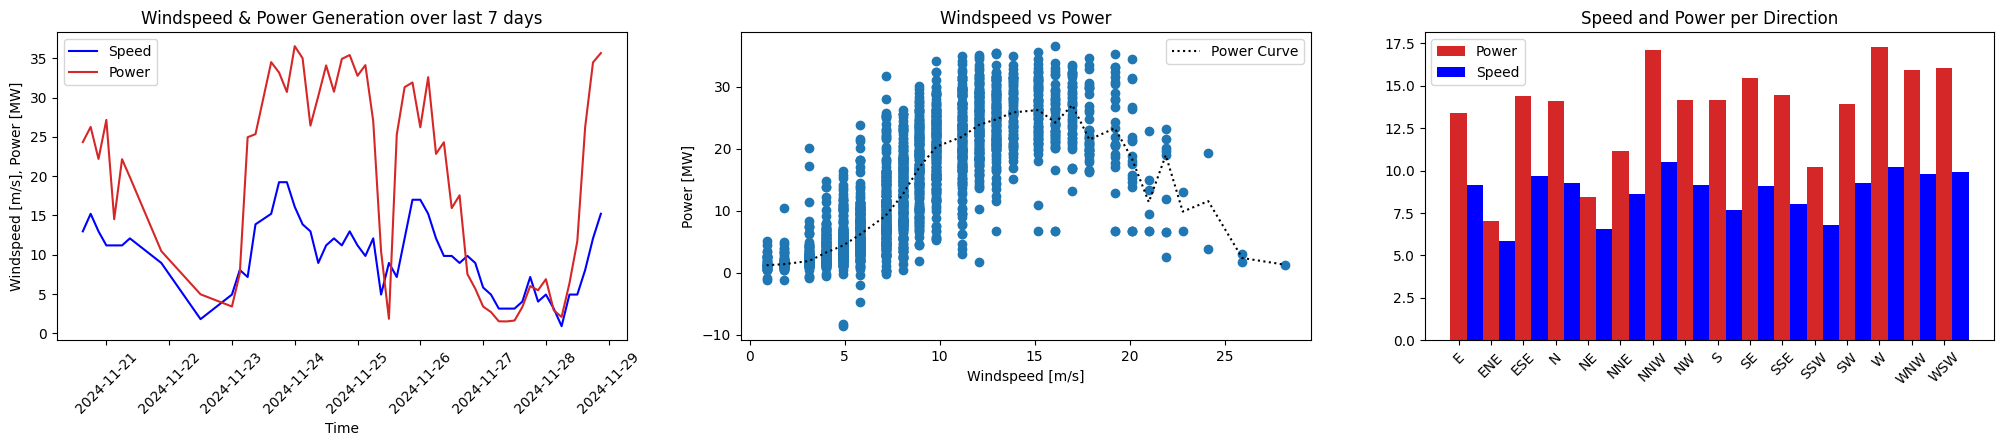

In [344]:
subplot_wind_power(joined_dfs_inner, 7, 3)

**NOTE:** <em>These plots should already give us an intuition of the different relationships between features. It seems clear that there is a positive relationship between the wind speed and the power generation from the turbines, as we obviously suspected. But that relationship is not completely linear. Can you spot that? Finally, it seems like the power generation also depends of where the winds is coming from. Maybe this could also be a useful feature.</em> 

In order to plot the relationship between wind speed and power generation we have performed a very simple join with the two datasets. But since the intervals are not the same, a lot of data is discarded (<em>can you spot where in the code this happens?</em>). You may want to explore other ways to merge the data sources to minimize the loss of information.

<div style="color: green"> subplotting as a function </div>

In [345]:
def subplot_wind_power2(data, days:int, interval:int, plotlength: int): #plotlength: int
    # Subplots
    fig, ax = plt.subplots(1, 3, figsize=(25, 4))
    # matplotlib.use('svg')
    # matplotlib.use("TkAgg")

    # Speed and Power for the last 7 days
    ax[0].plot(
        data["Speed"].tail(int(days * 24 / interval)), label="Speed", color="blue"
    )  # Since the datasets are joined every three hours, we need the last 7 days times 24 hours diveded by 3 hours
    ax[0].plot(
        data["Total"].tail(int(days * 24 / interval)), label="Power", color="tab:red"
    )  # Since the datasets are joined every three hours, we need the last 7 days times 24 hours diveded by 3 hours
    ax[0].set_title("Windspeed & Power Generation over last 7 days")
    ax[0].set_xlabel("Time")
    ax[0].tick_params(axis="x", labelrotation=45)
    ax[0].set_ylabel("Windspeed [m/s], Power [MW]")
    ax[0].legend()

    # Speed vs Total (Power Curve nature)
    ax[1].scatter(data["Speed"], data["Total"])
    power_curve = data.groupby("Speed").median(numeric_only=True)["Total"]
    ax[1].plot(power_curve.index, power_curve.values, "k:", label="Power Curve")
    ax[1].legend()
    ax[1].set_title("Windspeed vs Power")
    ax[1].set_ylabel("Power [MW]")
    ax[1].set_xlabel("Windspeed [m/s]")

    # Speed and Power per Wind Direction
    wind_grouped_by_direction = (
        data.groupby("Direction").mean(numeric_only=True).reset_index()
    )
    bar_width = 0.5
    x = np.arange(len(wind_grouped_by_direction.index))

    # changed wind_grouped_by_direction to .Speed in accorance to the learnIT question.
    ax[2].bar(
        x, wind_grouped_by_direction.Total, width=0.5, label="Power", color="tab:red"
    )
    ax[2].bar(
        x + bar_width,
        wind_grouped_by_direction.Speed,
        width=0.5,
        label="Speed",
        color="blue",
    )
    ax[2].legend()
    ax[2].set_xticks(x)
    ax[2].set_xticklabels(wind_grouped_by_direction.Direction)
    ax[2].tick_params(axis="x", labelrotation=45)
    ax[2].set_title("Speed and Power per Direction")

    plt.savefig(f"{plotlength}_day_figs.png")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

<div style="color: green">EXTRA EDA ON THE DATA </div>

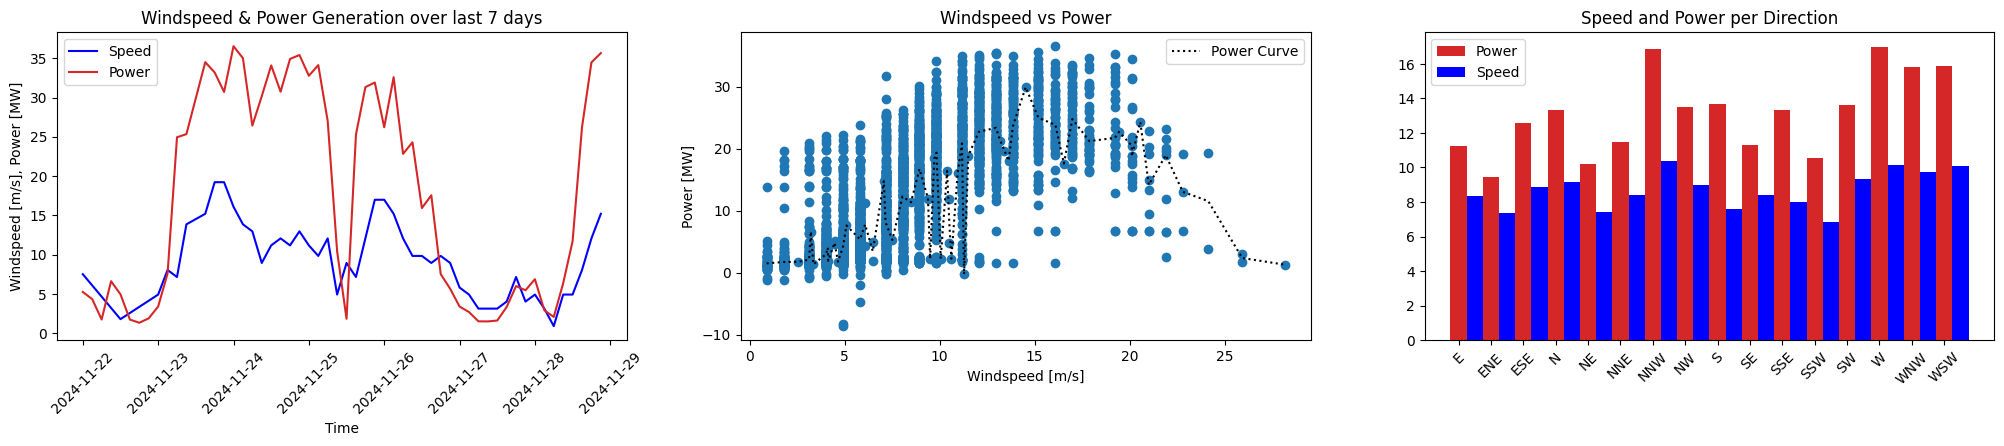

In [346]:
### TODO -> DO SOME EXTRA EDA ON THE DATA ###
# subplotwindpower calibrated to the first join I'm assuming. Since both plots are practically identical

subplot_wind_power2(joined_dfs, 7, 3, 90)

In [347]:
joined_dfs["Direction"].unique()

array(['ENE', 'NE', 'NNE', 'NW', 'SSW', 'S', 'SW', 'SSE', 'ESE', 'E', 'N',
       'WNW', 'WSW', 'SE', 'W', 'NNW'], dtype=object)

In [348]:
# Create a mapping dictionary of radians and wind directions
direction_to_radians = {
    "N": 0,
    "NNE": np.pi / 8,
    "NE": np.pi / 4,
    "ENE": 3 * np.pi / 8,
    "E": np.pi / 2,
    "ESE": 5 * np.pi / 8,
    "SE": 3 * np.pi / 4,
    "SSE": 7 * np.pi / 8,
    "S": np.pi,
    "SSW": 9 * np.pi / 8,
    "SW": 5 * np.pi / 4,
    "WSW": 11 * np.pi / 8,
    "W": 3 * np.pi / 2,
    "WNW": 13 * np.pi / 8,
    "NW": 7 * np.pi / 4,
    "NNW": 15 * np.pi / 8,
}

# 'df' = {
#     "Direction": [
#         "N",
#         "NNE",
#         "NE",
#         "ENE",
#         "E",
#         "ESE",
#         "SE",
#         "SSE",
#         "S",
#         "SSW",
#         "SW",
#         "WSW",
#         "W",
#         "WNW",
#         "NW",
#         "NNW",
#     ]
# }

# Map wind directions to radians
joined_dfs['Radians'] = joined_dfs["Direction"].map(direction_to_radians)

In [349]:
# #simple plotting of the wind directions
# plt.plot(df.index, df["Radians"], marker="o")
# plt.xlabel("Index")
# plt.ylabel("Radians")
# plt.title("Wind Directions in Radians")
# plt.show()

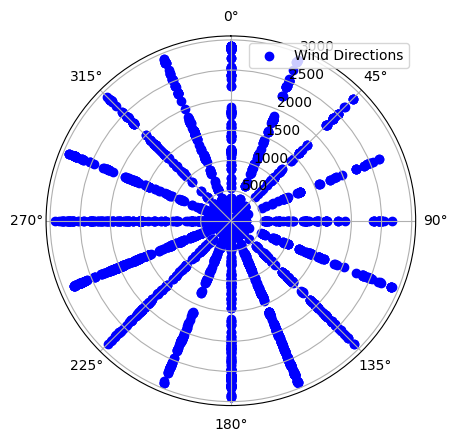

In [350]:
# Convert radians to angles for polar plot
angles = joined_dfs["Radians"].values
values = np.arange(len(angles))  # Values for plotting

# Polar plot
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.scatter(angles, values, c="blue", label="Wind Directions")
ax.set_theta_zero_location("N")  # North at top
ax.set_theta_direction(-1)  # Clockwise
ax.legend()
plt.show()

<div style="color: red"> Simple Plot: </div>
Useful for seeing how wind directions change over time.
Radians are linear, so transitions between directions (e.g., N to E) might look like jumps.
Polar Plot:
Provides a more intuitive representation of directional data.
Ensure the direction (set_theta_direction) and starting point (set_theta_zero_location) align with your needs.

In [351]:
#joined_dfs as it has the filled data cells
direction_analysis = joined_dfs.groupby("Direction")[["Total", "Speed"]].mean()
print(direction_analysis)

               Total      Speed
Direction                      
E          11.247108   8.346042
ENE         9.431127   7.392126
ESE        12.587944   8.884577
N          13.352822   9.138956
NE         10.181686   7.430347
NNE        11.449658   8.413293
NNW        16.844109  10.362491
NW         13.524628   8.994081
S          13.665330   7.581727
SE         11.308624   8.404522
SSE        13.311711   7.981145
SSW        10.543287   6.841309
SW         13.642230   9.352033
W          16.985636  10.142351
WNW        15.821901   9.711944
WSW        15.862104  10.109666


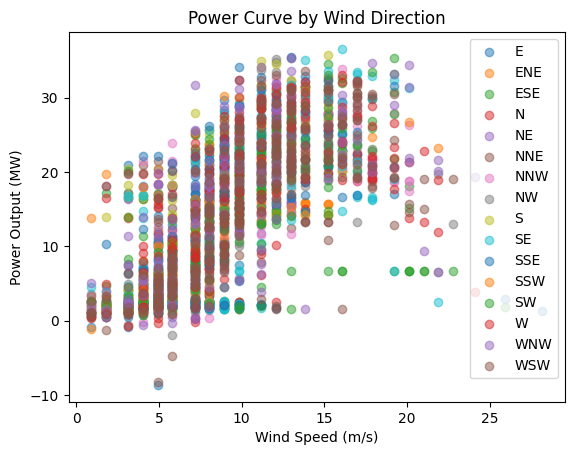

In [352]:
for direction, group in merged_data.groupby("Direction"):
    plt.scatter(group["Speed"], group["Total"], label=direction, alpha=0.5)
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Power Output (MW)")
plt.legend()
plt.title("Power Curve by Wind Direction")
plt.show()

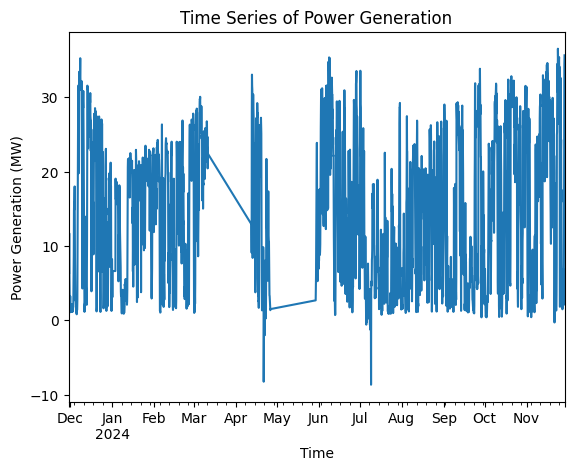

In [353]:
# Looking into relationship between power generation and wind-speed over time.. problems with lower time than intended.
joined_dfs["Total"].plot()
plt.xlabel("Time")
plt.ylabel("Power Generation (MW)") #megawatts
plt.title("Time Series of Power Generation")
plt.show()

In [354]:
# Feature checking for Wind Direction by converting string directions into numerics and decomposing into sinus and cosinus componets to look for circularity
joined_dfs['sin_direction'] = np.sin(joined_dfs['Radians'])
joined_dfs['cos_direction'] = np.cos(joined_dfs['Radians'])
joined_dfs.head()

,Total,Direction,Lead_hours,Source_time,Speed,Radians,sin_direction,cos_direction
time,,,,,,,,
2023-11-29 21:00:00+00:00,14.203750,ENE,1,1.701295e+09,8.04672,1.178097,0.923880,0.382683
2023-11-30 00:00:00+00:00,14.203750,ENE,1,1.701295e+09,8.04672,1.178097,0.923880,0.382683
2023-11-30 03:00:00+00:00,11.347290,ENE,1,1.701306e+09,8.04672,1.178097,0.923880,0.382683
2023-11-30 06:00:00+00:00,6.245817,NE,1,1.701317e+09,11.17600,0.785398,0.707107,0.707107
2023-11-30 09:00:00+00:00,11.720429,NE,1,1.701328e+09,11.17600,0.785398,0.707107,0.707107


In [355]:
#No cluster coulmn, as that would need to be added after PCA clustering
# plt.scatter(
#     joined_dfs["sin_direction"],
#     joined_dfs["cos_direction"],
#     c=joined_dfs["Cluster"],
#     cmap="viridis",
# )
# plt.xlabel("Sin(Direction)")
# plt.ylabel("Cos(Direction)")
# plt.title("Clusters of Wind Directions")
# plt.show()

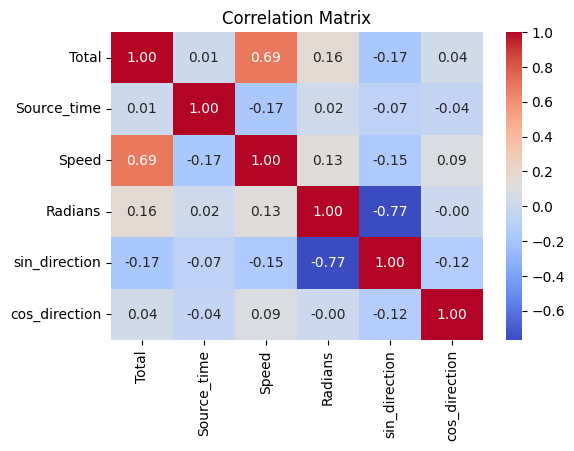

In [356]:
# Exploratory heatmap inspired by Introduction to Machine learning to look at correlation in the data, wind speed, lead time and power gen
numeric_data = joined_dfs.select_dtypes(include=["number"])
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [357]:
# # attempt at a preprocessing class for the pipeline
# class DataPreprocessor:
#     def __init__(self, client: InfluxDBClient):
#         self.client = client

#     def query_data(self, days: int):
#         """
#         Query the power and wind data for the last 'days' days.
#         """
#         power_set = self.client.query(
#             "SELECT * FROM Generation where time > now()-" + str(days) + "d"
#         )
#         wind_set = self.client.query(
#             "SELECT * FROM MetForecasts where time > now()-"
#             + str(days)
#             + "d and time <= now() and Lead_hours = '1'"
#         )

#         power_df = self.set_to_dataframe(power_set)
#         wind_df = self.set_to_dataframe(wind_set)

#         return power_df, wind_df

#     def set_to_dataframe(self, data_set):
#         """
#         Converts the InfluxDB query result into a pandas DataFrame.
#         """
#         df = pd.DataFrame(list(data_set.get_points()))
#         df.set_index("time", inplace=True)
#         df.index = pd.to_datetime(df.index)  # Ensure the index is a datetime type
#         return df

#     def align_and_resample(self, power_df, wind_df, interval="3H"):
#         """
#         Align the data frames and resample them based on the specified interval.
#         Interpolate missing values.
#         """
#         # Resample and interpolate
#         power_resampled = power_df.resample(interval).interpolate()
#         wind_resampled = wind_df.resample(interval).interpolate()

#         # Merge the datasets
#         merged_data = pd.merge(
#             power_resampled,
#             wind_resampled,
#             how="outer",
#             left_index=True,
#             right_index=True,
#         )

#         merged_data.interpolate(inplace=True)  # Interpolate any missing values

#         return merged_data

#     def preprocess(self, days: int, interval="3H"):
#         """
#         Main method that calls the query and preprocess functions.
#         """
#         power_df, wind_df = self.query_data(days)
#         merged_data = self.align_and_resample(power_df, wind_df, interval)
#         return merged_data

#     def plot_wind_power(self, data, days: int, interval: int):
#         """
#         Plot wind speed vs power generation for the last 'days' days.
#         """
#         import matplotlib.pyplot as plt

#         fig, ax = plt.subplots(1, 3, figsize=(25, 4))

#         # Speed and Power for the last 'days' days
#         ax[0].plot(
#             data["Speed"].tail(int(days * 24 / interval)), label="Speed", color="blue"
#         )
#         ax[0].plot(
#             data["Total"].tail(int(days * 24 / interval)),
#             label="Power",
#             color="tab:red",
#         )
#         ax[0].set_title("Windspeed & Power Generation over last 7 days")
#         ax[0].set_xlabel("Time")
#         ax[0].tick_params(axis="x", labelrotation=45)
#         ax[0].set_ylabel("Windspeed [m/s], Power [MW]")
#         ax[0].legend()

#         # Speed vs Total (Power Curve nature)
#         ax[1].scatter(data["Speed"], data["Total"])
#         power_curve = data.groupby("Speed").median(numeric_only=True)["Total"]
#         ax[1].plot(power_curve.index, power_curve.values, "k:", label="Power Curve")
#         ax[1].legend()
#         ax[1].set_title("Windspeed vs Power")
#         ax[1].set_ylabel("Power [MW]")
#         ax[1].set_xlabel("Windspeed [m/s]")

#         # Speed and Power per Wind Direction
#         wind_grouped_by_direction = (
#             data.groupby("Direction").mean(numeric_only=True).reset_index()
#         )
#         bar_width = 0.5
#         x = np.arange(len(wind_grouped_by_direction.index))

#         ax[2].bar(
#             x,
#             wind_grouped_by_direction.Total,
#             width=0.5,
#             label="Power",
#             color="tab:red",
#         )
#         ax[2].bar(
#             x + bar_width,
#             wind_grouped_by_direction.Speed,
#             width=0.5,
#             label="Speed",
#             color="blue",
#         )
#         ax[2].legend()
#         ax[2].set_xticks(x)
#         ax[2].set_xticklabels(wind_grouped_by_direction.Direction)
#         ax[2].tick_params(axis="x", labelrotation=45)
#         ax[2].set_title("Speed and Power per Direction")

#         plt.tight_layout()
#         plt.show()

## Step 2: Pipeline and data transformations

Now that we have our data, we need to construct the pipeline to process this data and pass it to our Machine Learning model. For this, you may find useful the Pipeline class from Scikit-Learn.

This class applies a list of transforms to your data, and pass the final state to an estimator (your model). Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods. The final estimator only needs to implement fit. 

The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. For this, it enables setting parameters of the various steps using their names and the parameter name separated by a '__'. 

You can find more information about Scikit-Learn's Pipeline [here](https://scikit-learn.org/stable/modules/compose.html#pipeline).

#### Example

Attempt at making use of the Pipeline element

In [358]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (accuracy_score) # Accuracy metric. Consider using Precision, Recall, F1 Score or AUC. accuracy_score is meant for classification problems where y_test => categorical ie. classes
from sklearn.metrics import r2_score # Measures the proportion of variance in the target variable explained by the model.
from sklearn.metrics import (mean_squared_error)  # rmse = mean_squared_error(y_test, yhat, squared=False) to get the RMSE
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import mlflow.sklearn

In [359]:
# Features as our X, target variable as our y.
features = ["Speed", "sin_direction", "cos_direction"]
target = "Total"

X = joined_dfs[features]
y = joined_dfs[target]

In [360]:
# A very basic pipeline
pipeline_example = Pipeline([
    # Transformations
    ("Scaler", StandardScaler()),
    # Estimator
    ("Linear Regression", LinearRegression())
])

In [361]:
### TODO -> CREATE YOUR OWN PIPELINE ###
# Create your pipeline with the desired transformers
pipeline = Pipeline([

    # Transformer 1
    # Transformer 2
    # ...
    # Final estimator
])

In [362]:
# have to change formatting a bit. Given we're working with the Pipeline setup instead of the make_pipeline setup. From 'lr':make_pipeline(StandardScaler(), LogisticRegression()) ->
pipelines = {
    "linr": Pipeline([("scaler", StandardScaler()), ("regressor", LinearRegression())]),
    "gb": Pipeline([("scaler", StandardScaler()), ("regressor", GradientBoostingRegressor())]),
    "rf": Pipeline([("scaler", StandardScaler()), ("regressor", RandomForestRegressor())]),
}

## Evaluate your model

Now that you have a preprocessing pipeline ready, along with the final estimator, you may want to know how well your model performs. Choose the method you prefer, with special attention to the selected metric.

#### Example

In [363]:
# # Select our feature variables and our target variable.
# joined_dfs_eval = power_df.join(wind_df).dropna()

# X = joined_dfs_eval["Speed"].values.reshape(-1, 1)
# y = joined_dfs_eval["Total"].values.reshape(-1, 1)

# # Split the data so we can test how well our model performs in unseen data
# X_train, X_test, y_train, y_test = train_test_split(X, y) # -> You might want to use another split method

# # Train our model
# pipeline_example.fit(X_train, y_train)

# # Evaluate the model, using MAE as a metric
# mae = mean_absolute_error(pipeline_example.predict(X_test), y_test)
# print(mae)

**HINTS:** <em>Pay special attention to this type of data: We are dealing with Time series data (i.e. data that is recorded over consistent intervals of time). It might be a good idea not to **randomly** split the data, since it wouldn't respect the temporal order and may cause data-leakage, unintentionally inferring the trend of future samples.</em> 

In [364]:
# Use your preferred method to evaluate your model
### TODO -> SPLIT THE DATA INTO TRAIN AND TEST SETS, AND EVALUATE YOUR MODEL ###

Dataframe splitting

In [365]:
# # regular train_test_split
# # could add the interpolate step here instead of during the initial preprocessing
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
# print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

In [366]:
# for timeseries split
joined_dfs_indexed = joined_dfs.sort_index()

time_interval = int(24/3) *30 #*15
gap_interval = int(24/3) # gap of 1 day, ie. 8 entries
tscv = TimeSeriesSplit(n_splits=3, test_size=time_interval, gap=gap_interval) #split 4 if 365, split 3 for 180

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    #print(f'Fold {fold + 1}')

    test_index = test_index[:time_interval]  # Restrict test set size
    train_index = train_index[:-gap_interval]

    #splitting data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [367]:
def timeseries_split(dataframe, n_splits: int ):
    dataframe = dataframe.sort_index()

    time_interval = int(24 / 3) * 15  # 30
    gap_interval = int(24 / 3)  # gap of 1 day, ie. 8 entries
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=time_interval, gap=gap_interval)

    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        # print(f'Fold {fold + 1}')

        test_index = test_index[:time_interval]  # Restrict test set size
        train_index = train_index[:-gap_interval]

        # splitting data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    return X_train, X_test, y_train, y_test

In [368]:
# testing splitting the data and applying the pipeline
def use_pipeline(pipeline): # Could change into also taking the (X, y) training data as parameters.
    pipeline.fit(X_train, y_train)

    yhat = pipeline_example.predict(X_test)
    mse = mean_squared_error(y_test, yhat)
    rmse = np.sqrt(np.mean((y_test - yhat) ** 2))
    r2 = r2_score(y_test, yhat)
    mae = mean_absolute_error(y_test,yhat)
    mean_tar = y_test.mean()
    mae_perc = (mae/mean_tar) * 100
    print(f'mae: {mae}, mae as percent of mean target {mae_perc:.2f}%')
    print(f"mse: {mse}, rmse: {rmse}, r^2: {r2}")

    return pipeline, mse, rmse, r2, mae

#use_pipeline(pipeline_example)

In [369]:
# Going through my dictionary of pipelines
# fit_models = {}
# for algo, pipeline in pipelines.items():
#     print(f"Fitting {algo} model...")
#     model = use_pipeline(pipeline)
#     fit_models[algo] = model

In [370]:
# singular cell to create error metric variables outside of our function
# yhat = pipeline_example.predict(X_test)
# mse = mean_squared_error(y_test, yhat)
# rmse = np.sqrt(np.mean((y_test - yhat) ** 2))
# r2 = r2_score(y_test, yhat)
# mae = mean_absolute_error(y_test,yhat)
# mean_tar = y_test.mean()
# mae_perc = (mae/mean_tar) * 100

In [371]:
# Making a param grid dictionary
param_grid_dictionary = {
    "linr": {
        "regressor__fit_intercept": [True, False], ## do we have a an intercept in y= mx + b, false if centered data
        # depreciated setup. Have to create separate pipelines without std scaler "regressor__normalize": [True, False], ## include normalization of the data or not, autocovered by standardscaler()
    },
    "gb": {
        "regressor__n_estimators": [50, 100], ## the range of boosting stages, normally weighing of balance between computation and risk of overfitting
        "regressor__learning_rate": [0.01, 0.1], ## How much is the contribution of each tree scaled. Smaller value = slower, but better generalization. high n => smaller value for learning rate to reduce overfitting
        "regressor__max_depth": [3, 5], ## The range of the the depth of each tree. Smaller values less overfitting, depth 5 more complexity.
    },
    "rf": {
        "regressor__n_estimators": [100, 200], ## similar to gb, but here 100 is common starting point, and range to 200 reduces variance at the cost of increased running time
        "regressor__max_depth": [5, 10], ## less lenient compared to gb when it comes to tree depth, hence I start with 5 -> 10
        "regressor__min_samples_split": [2, 5], ## min number required for an internal node to split. Here smaller number = more flexible, but more prone to overfitting
    },
}

In [372]:
# def one_hot_encoding_experiment(data: pd.DataFrame, taget_column: str, categorical_coulumn: str, test_size: int, test): 
#     """
#     Perform a one-hot encoding experiment on a dataset.
    
#     Parameters:
#         data (pd.DataFrame): The input dataset.
#         target_column (str): Name of the target variable column.
#         categorical_column (str): Name of the categorical column to one-hot encode.
#         test_size (int): Number of n splits to be done on the dataset.
#         random_state (int): Random state for reproducibility.
    
#     Returns:
#         dict: A dictionary with model performance and the modified dataset.
#     """

## Step 3: Tracking your experiments with MLFlow

We have a working model with a certain accuracy. But wouldn't it be better to try different parameters and different models before deciding for one? <br><br>
This is exactly what we will do using the MLFlow library. MLflow is an open source platform to manage the ML lifecycle, including experimentation, reproducibility, deployment, and a central model registry. This will allow us for easy comparison of all our model experiments. <br>

**NOTE:**<em> Don't forget to check the [MLFlow documentation](https://mlflow.org/docs/latest/index.html) to learn more about the library.</em>

#### Example

When using MLFlow locally to log our experiments, we need to start a "local server". We can do this easily by running the following in our command line interface:

```
mlflow server
```

For example, using PowerShell, it should look like this:

![MLFlow Server](https://github.com/ginofazzi/testing/raw/0d3ffce58ee12f6d1c86b6a3c2ac628314e7b82e/mlflow_server.png)

In this example, we can see that the server is located at our localhost 127.0.0.1, port 5000. We will use this information to indicate MLFlow where to save our experiment details.

My mlflow on desktop: http://127.0.0.1:5000


In [373]:
# # Start an MLflow run
# mlflow.sklearn.autolog() # This is to help us track scikit learn metrics.
# mlflow.set_tracking_uri("http://127.0.0.1:5000") # We set the MLFlow UI to display in our local host.

# # Set the experiment and run name
# experiment_name = "LinearRegression-Example_tscv" # I suggest using a different experiment for each model
# run_name = "Simple_regression-test" # I suggest using a different run name for each tried parameter

# mlflow.set_experiment(experiment_name)

# with mlflow.start_run(run_name=run_name) as run:

#     # Train our model
#     pipeline_example.fit(X_train, y_train)

#     # Evaluate the model, using MAE as a metric
#     predictions = pipeline_example.predict(X_test)
#     mae = mean_absolute_error(predictions, y_test)

#     mlflow.log_metric("MAE", mae)
#     # mlflow.log_metric("RMSE", rmse)
#     # mlflow.log_metric("r^2", r2)

<div style="color: red"> Small reflection </div>
Due to size contraints based on 90 days of data and the timeseriessplit setup, I need to adjust the interval to be based on 15 days instead of every 30 days, as I run outta testing samples.

In [ ]:
### TODO -> SET YOUR OWN EXPERIMENT SETUP ###
"""
Here, you may want to stop and think what is the best way to iterate(!) through all the models and experiments you want to try.
Instead of running your code everytime you want to change something, you could try to list all your desired experiments and
run them all sequentially in one go (gridsearch style).
"""

# Start an MLflow run
mlflow.sklearn.autolog(disable=True)  # This is to help us track scikit learn metrics.
mlflow.set_tracking_uri("http://127.0.0.1:5000")  # We set the MLFlow UI to display in our local host.

# Set the experiment and run name
experiment_name = "GridSearch_experiment_90days"  # I suggest using a different experiment for each model
# run_name = "Simple_regression-test"  # I suggest using a different run name for each tried parameter
mlflow.set_experiment(experiment_name)


# gridsearch on each pipeline
for model_name, pipeline in pipelines.items():
    print(f"Running GridSearch for {model_name}...")

    grid_search = GridSearchCV(pipeline, param_grid_dictionary[model_name], cv=tscv, n_jobs=-1, verbose=1)
    run_name = f"{model_name}_GridSearch90"
    with mlflow.start_run(run_name= run_name) as run:

        grid_search.fit(X_train, y_train)

        # Get best model and parameters
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # Log the best parameters to MLflow
        # mlflow.log_params(best_params)

        # manually logging params
        for param_name, param_value in best_params.items():
            mlflow.log_param(param_name, param_value)

        # Make predictions
        yhat = best_model.predict(X_test)

        # Calculate metrics
        mae = mean_absolute_error(y_test, yhat)
        mse = mean_squared_error(y_test, yhat)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, yhat)

        # Log metrics to MLflow
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("MSE", mse)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("R2", r2)

        # log specific model
        mlflow.sklearn.log_model(best_model, artifact_path='model')

        print(f"Best params for {model_name}: {best_params}")
        print(f"MAE: {mae}, RMSE: {rmse}, R^2: {r2}")

## Comparing models

Now we have run our experiment(s), trying different pre-processing steps, models and parameters. To easily compare the results from our experiments, we can use the MLFlow interface.

#### Example

We have been logging our experiments in our local server. We can access the UI by opening the localhost address in any browser. When opening the server in the browser, we should see something like this:

![MLFlow UI](https://github.com/ginofazzi/testing/raw/0d3ffce58ee12f6d1c86b6a3c2ac628314e7b82e/MLFLowUI.png)

In this example, we can see the list of all our experiments in the left, and for each experiment a table with all the different runs.

**NOTE:**<em> This example contains only one run for the experiment. When logging multiple runs with different parameters/metrics, you will be able to easily compare them using the "Chart View". Make sure to try this out.</em>


## Saving the best model

Now that we have tried many different models with different parameters, we might want to save the best one. To do this, we can use again the UI:

1. In the Experiments list, select the model you want to save. In the Table view, select the version of that model (Run name).
2. On the left, you will see all the experiment's run details (Parameters, metrics, and ML Project files). Click on "Register Model".
3. Now, on the "Models" tab, you will be able to see your saved model.

![MLFlow save model](https://github.com/ginofazzi/testing/raw/0d3ffce58ee12f6d1c86b6a3c2ac628314e7b82e/MLFLow-save_model-1.png)

In case of doubt, you can check the documentation [HERE](https://mlflow.org/docs/latest/model-registry.html).

## Step 4: Using a saved model

Now that we have saved our best model, we might want to use it for future predictions. We can retrieve the weather forecasts for the next days, and make predictions of power generation.

#### Example

First we need the new forecast data:

In [375]:
# Get all future forecasts regardless of lead time
forecasts  = client.query(
    "SELECT * FROM MetForecasts where time > now()") # Query written in InfluxQL

# Transform the result set into a dataframe
forecasts = set_to_dataframe(forecasts)

# Limit to only the newest source time, so we have the latest forecast only
newest_forecasts = forecasts.loc[forecasts["Source_time"] == forecasts["Source_time"].max()].copy()

Then, we can retrieve any saved model and use it to predict on the new data:

In [376]:
# Specify the model details
model_name = "Gradient_Boosting_365"
model_version = 1

# Use MLFlow to load the saved model
model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{model_version}")

# Use the saved model to predict the power generation
predictions = model.predict(newest_forecasts[["Speed"]])

# We can transform the predictions array to a Pandas DataFrame
predictions = pd.DataFrame(predictions, index=newest_forecasts.index, columns=["Power"])
predictions.head()

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- cos_direction
- sin_direction


### Retrain your model and keep the best one

Now we now how to retrieve saved models, it might be a good idea to validate our models troughout time, with new data, and keep the best one every time.

In [ ]:
### TODO -> INSERT YOUR CODE HERE ###
"""
You might want to think how to systematically test your model with new data, 
compare with the metrics of the best saved model, and update your model if 
necessary. 
"""

## Step 5: Deploying your model

So far, we have trained several models and saved the best for predictions. But we have been working locally. Often times, we will want to deploy our model in such a way that other people can take advantage of it, by sending a request with data and getting back predictions. To do this, we need to create an endopoint for our model to receive data. This is done through deployment of the model.

To deploy our model, we first need to serve the model. Serving a model refers to the process of making a trained machine learning model available to receive input data and provide predictions or inferences based on that data. In other words, when you serve a model, you set it up in a way that it can be queried with new data, and it will produce predictions or outputs based on the patterns it learned during training.

Serving a model is a critical step in the machine learning lifecycle, as it allows you to leverage the model's predictive capabilities in real-world applications. When a model is served, it becomes accessible to applications, websites, or other systems that need to utilize its predictions.

To deploy your model, follow section 3.3 from the Assignment PDF. If you want to learn how to deploy models from the Jupyter Notebook, try out the tutorial notebook at examples/sklearn_elasticnet_wine/train.ipynb. You can find it on the [MLFlow Tutorial](https://mlflow.org/docs/latest/tutorials-and-examples/tutorial.html). 

